# Port Recognition

Very similar to scalable vertex recognition. Read that manual.

#### Learnings:
* Watch out: no white pixel in a plot does not mean that there is no white data point!!!
* Convert shapes: rsvg-convert output.svg -w 20 -h 20 -o output.png 

In [70]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go

### Input and Transparency (Alpha) Management

In [71]:
activate_plotly = False
threshold = 0.4 # finds 2 ports

# Define the paths
target_image_path = "images/testcase2.png"
template_image_path = "images/io.png"

target_img = cv2.imread(target_image_path)
template_img = cv2.imread(template_image_path)

template_img = cv2.resize(template_img, (20, 20))

#### Visualization of Input

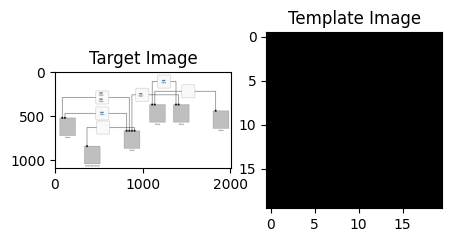

In [72]:
# plot target image and template_img_with_alpha
fig, ax = plt.subplots(1, 2, figsize=(5, 10))
ax[0].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Target Image')
ax[1].imshow(cv2.cvtColor(template_img, cv2.COLOR_BGRA2RGBA))
ax[1].set_title('Template Image')
plt.show()

### Template Matching

For some reason TM_SQDIFF_NORMED is not normed to 0..1, this could be because of mask of 3 channels.

Template matching works with mask but only for the template [SO](https://stackoverflow.com/a/44693722)
Docu template matching [opencv tut](https://docs.opencv.org/3.4/de/da9/tutorial_template_matching.html)
[opencv doc](https://docs.opencv.org/3.0.0/df/dfb/group__imgproc__object.html#ga586ebfb0a7fb604b35a23d85391329be)

Great explanation why we should use a least squares the key is that on a white background you would have to problem of dividing by zero. [SO](https://stackoverflow.com/questions/44690002/python-opencv-matchtemplate-on-grayscale-image-with-masking)

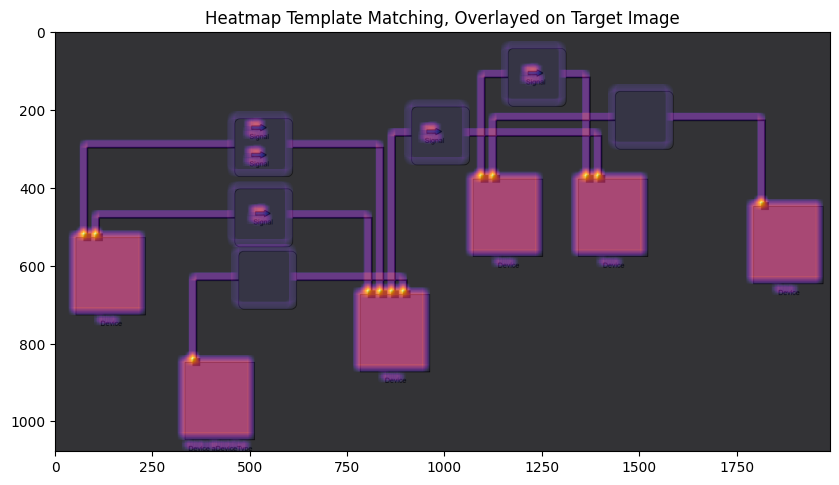

In [73]:
# Apply template matching
# res = cv2.matchTemplate(target_img, template_img, cv2.TM_CCOEFF_NORMED, mask=template_alpha_mask_3)

# res = cv2.matchTemplate(target_masked, template_img, cv2.TM_CCORR_NORMED, mask=template_alpha_mask)
# res = cv2.matchTemplate(target_masked, template_img, cv2.TM_CCOEFF_NORMED)
# res = cv2.matchTemplate(target_img, template_img, cv2.TM_SQDIFF, mask=template_alpha_mask_3 ) # working
res = cv2.matchTemplate(target_img, template_img, cv2.TM_SQDIFF) # experiment to normalize

# Overlay non logarithmic heatmap on the original image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax.imshow(res, cmap='inferno_r', alpha=0.8, interpolation='nearest')  # `alpha` controls the transparency.
plt.title('Heatmap Template Matching, Overlayed on Target Image')
plt.show()

#### Template Matching Debug Output

In [74]:
# print max of res
print('Max of res: ', np.max(res))
# print min of res
print('Min of res: ', np.min(res))
print('Shape of res: ', res.shape)

# print shape of template and target
print('Shape of template: ', template_img.shape)
print('Shape of target: ', target_img.shape)

# print the data types
print('Data type of template: ', template_img.dtype)
print('Data type of target: ', target_img.dtype)



Max of res:  78030000.0
Min of res:  0.0
Shape of res:  (1077, 1990)
Shape of template:  (20, 20, 3)
Shape of target:  (1096, 2009, 3)
Data type of template:  uint8
Data type of target:  uint8


#### Visualization of Template Matching 3D with plotly with screenshot for paper

In [75]:
# template matching data processing
template_matching_result = res.copy()
# z_data = -np.log(template_matching_result[::-1])
z_data = template_matching_result[::-1]
# mirror z_data
z_data = np.flipud(z_data)

# target image data processing
target_img_cropped = target_img[:template_matching_result.shape[0], :template_matching_result.shape[1], :]
target_img_cropped_gray = cv2.cvtColor(target_img_cropped, cv2.COLOR_BGR2GRAY)
# z_image = np.ones_like(target_img_cropped_gray)*-16.8 # 16.7 is good
z_image = np.ones_like(target_img_cropped_gray)*0.8 # 0.8 is good
z_image = np.flipud(z_image)


activate_plotly = False
if activate_plotly:
    fig = go.Figure()

    # Layer 1: 3D Plot of Heatmap
    fig.add_trace(go.Surface(
        z=z_data,
        showscale=False,
        colorscale='inferno_r'
        ))

    # Layer 2: 2D Plot of Target Image at 0.1 (for aesthetics)
    fig.add_trace(go.Surface(
        z=z_image, 
        surfacecolor=target_img_cropped_gray, 
        colorscale='gray', 
        showscale=False
        ))
    
    fig.update_layout(title='Heatmap Template Matching', 
                      scene=dict(
                        yaxis=dict(autorange='reversed'),
                        zaxis=dict(autorange="reversed") 
                      ),
                      height=1500,
                      scene_aspectratio=dict(x=2, y=1, z=0.5),
                      )
    fig.show()

## Thresholding

## Visualization after Thresholding

### Threshold Template Matching

In [76]:

# IDEA: make threshold in %, somehow related to area.
# and analyse with plotly what else is almost detected
loc = np.where(res < threshold)
print(f"Found {len(loc[0])} matches with a threshold of {threshold}")

Found 12 matches with a threshold of 0.4


### Analysis After Thresholding

In [77]:
# Set all values over the threshold to 1 (was 2e7) (which kind of resembles "zero")
thresholded_res = np.copy(res)
thresholded_res[thresholded_res > threshold] = 1

#### 2D big Xes on Target Image

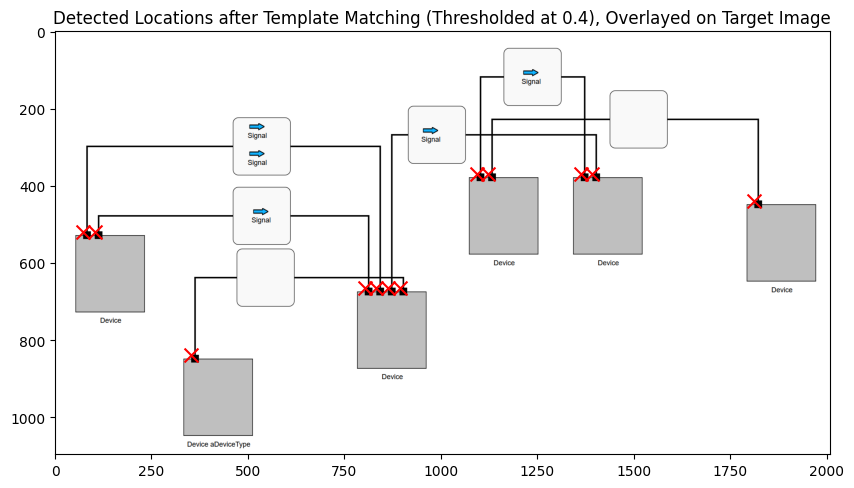

In [78]:
# draw the loc as points
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax.scatter(loc[1], loc[0], c='r', s=100, marker='x')
plt.title(f'Detected Locations after Template Matching (Thresholded at {threshold}), Overlayed on Target Image')
plt.show()

### No Foreground Filter
but small conversion of result

In [79]:
"""Case ports: no need to check for foreground. Just return the all points. Background: tranpsarent, so no need to check for foreground."""
loc_converted = []
for pt in zip(*loc[::-1]):
    loc_converted.append(pt)

print(loc_converted)

[(np.int64(1093), np.int64(369)), (np.int64(1123), np.int64(369)), (np.int64(1363), np.int64(369)), (np.int64(1393), np.int64(369)), (np.int64(1813), np.int64(439)), (np.int64(73), np.int64(519)), (np.int64(103), np.int64(519)), (np.int64(803), np.int64(665)), (np.int64(833), np.int64(665)), (np.int64(863), np.int64(665)), (np.int64(893), np.int64(665)), (np.int64(353), np.int64(839))]


### Fill bounding boxes

In [80]:
matched_templates_bbox_filled = np.zeros(target_img.shape[:2], dtype=np.uint8)
for pt in loc_converted:
    cv2.rectangle(matched_templates_bbox_filled, pt, (pt[0] + template_img.shape[1], pt[1] + template_img.shape[0]), 255, -1)

#### Plot filled bounding boxes

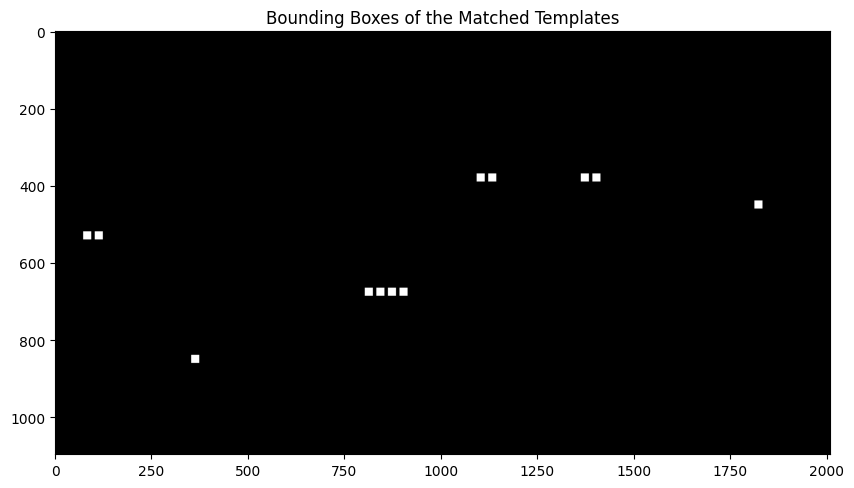

In [81]:
# Draw the result
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(matched_templates_bbox_filled, cmap='gray')
plt.title('Bounding Boxes of the Matched Templates')
plt.show()

### Find Contours in the super boxes

In [82]:
target_img_boundings_grouped = target_img.copy()

# Find contours
contours, _ = cv2.findContours(matched_templates_bbox_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Store the bounding boxes of the vertices
bounding_boxes = []

# Draw bounding boxes based on contours or compute their coordinates
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(target_img_boundings_grouped, (x, y), (x+w, y+h), (125, 255, 0), 4)
    bounding_boxes.append((x, y, w, h))
print(f"bounding_boxes: {bounding_boxes}")

bounding_boxes: [(353, 839, 21, 21), (893, 665, 21, 21), (863, 665, 21, 21), (833, 665, 21, 21), (803, 665, 21, 21), (103, 519, 21, 21), (73, 519, 21, 21), (1813, 439, 21, 21), (1393, 369, 21, 21), (1363, 369, 21, 21), (1123, 369, 21, 21), (1093, 369, 21, 21)]


#### Visualize the super boxes

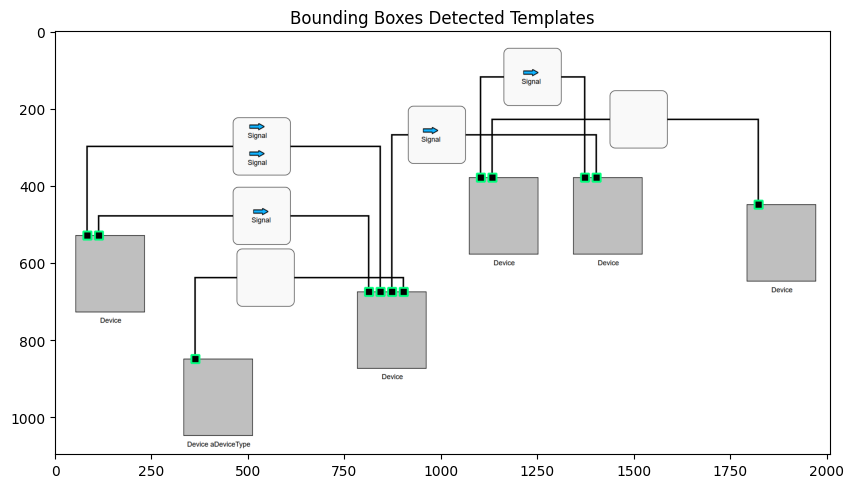

In [83]:
# Draw the result
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(target_img_boundings_grouped, cv2.COLOR_BGR2RGB))
ax.set_title("Bounding Boxes Detected Templates")
plt.show()